In [9]:
using LinearAlgebra
using Distributions
using Random
using SparseArrays
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Spectral-Navier-Stokes.jl");

# Navier-Stokes Problem

We consider the 2D Navier-Stokes equation on a periodic domain $D = [0,2\pi]\times[0,2\pi]$:

$$
\begin{equation*}
\begin{split}
    &\frac{\partial v}{\partial t} + (v\cdot \nabla) v + \nabla p - \nu\Delta v = f, \\
    &\nabla \cdot v = 0, \\
    &\frac{1}{4\pi^2}\int v  = v_b;
    \end{split}
\end{equation*}
$$

here $v$ and $p$ denote the velocity vector and the pressure, $\nu$ denotes the dynamic viscosity, $v_b$ denotes the non-zero mean background velocity, and $f$ denotes a zero-mean periodic forcing term (Hence, the mean background velocity will not change).


The forward problem can be rewritten in the vorticity-streamfunction ($\omega-\psi$) formulation:

$$
\begin{equation*}
\begin{split}
    &\frac{\partial \omega}{\partial t} + (v\cdot\nabla)\omega - \nu\Delta\omega = \nabla \times f, \\
    &\omega = \nabla \times v,\\
\end{split}
\end{equation*}
$$

with periodic initial condition $\omega = \omega_0$. The velocity is recovered from the vorticity through the streamfunction 

$$
\begin{equation*}
\begin{split}
    &\omega = -\Delta\psi \qquad \frac{1}{4\pi^2}\int\psi = 0,\\
    &v = \Big(\frac{\partial \psi}{\partial y}, -\frac{\partial \psi}{\partial x}\Big) + v_b,
\end{split}
\end{equation*}
$$

The Pressure can be computed from 

$$\Delta p = \nabla \cdot f + 2\Big(\frac{\partial u}{\partial x}\frac{\partial v}{\partial y} - \frac{\partial u}{\partial y}\frac{\partial v}{\partial x}\Big)$$

## Pseudo-Spectral Method

The solution $\omega$  is expanded in the fourier basis functions:
$$
\omega = \sum_{k_x\in{Z}, k_y\in{Z}}  \hat{\omega}_{k_x,k_y}(t)  e^{i (2\pi k_x\frac{x}{L_x} + 2\pi k_y\frac{y}{L_y})}
$$
here $L_x = L_y = 2\pi$ are the periodic domain sizes.


Assume the domain is discretized by $N_x+1$ and $N_y+1$ uniform grids in each direction with grid points

$$
\begin{align*}
&0 = x_0 < x_1 <\cdots < x_{N_x} = L_x \qquad 0 = y_0 < y_1 <\cdots < y_{N_y} = L_y
\end{align*}
$$

For the convinence of applying Discrete Fourier Transform, we rewrite the solution of $\omega$ as following 

$$
\omega = \frac{1}{N_xN_y}\sum_{k_x=-N_x/2}^{N_x/2-1}\sum_{k_y=-N_y/2}^{N_y/2-1} \hat{\omega}_{k_x,k_y}(t)  e^{i (2\pi k_x\frac{x}{L_x} + 2\pi k_y\frac{y}{L_y})}
$$

here we assume both $N_x$ and $N_y$ are even numbers.


By applying fourier transformation to the vorticity-streamfunction formulation, we have

$$
\frac{d \hat{\omega}_{k_x,k_y}}{d t} + \widehat{\Big((v\cdot\nabla)\omega\Big)}_{k_x,k_y} + 
\nu\Big(\frac{(2\pi k_x)^2}{L_x^2} + \frac{(2\pi k_y)^2}{L_y^2}\Big) \hat{\omega}_{k_x,k_y} = \widehat{\Big(\nabla \times f\Big)}_{k_x,k_y}
$$





## Advection Term and Dealiasing

To compute the advection term $(v\cdot\nabla)\omega$, we will first compute the velcity.
Luckily, solving Laplacian equation and computing gradients are almost free for pseudo-spectral methods. 

We have 

$$
\hat{\psi}_{k_x, k_y} 
= \sum_{k_x, k_y} \frac{\hat{\omega}_{k_x,k_y}}{\frac{(2\pi k_x)^2}{L_x^2} + \frac{(2\pi k_y)^2}{L_y^2}}
$$

It is worth mentioning, the $\hat{\psi}_{0, 0}$ is not well-defined, but the zero-mean condition leads to 
$\hat{\psi}_{0, 0} = 0$, and it does not affect the velocity.

The velocity can be recovered as

$$\hat{v}_{k_x, k_y} = \Big(i\frac{2\pi k_y}{L_y}\hat{\psi}_{k_x, k_y},\, -i\frac{2\pi k_x}{L_x}\hat{\psi}_{k_x, k_y}\Big)\qquad \hat{v}_{0, 0} =  v_b N_x N_y $$

Then we compute the gradient of the vorticity, 

$$\widehat{\Big(\nabla \omega\Big)}_{k_x, k_y} = \Big(i\frac{2\pi k_x}{L_x}\hat{\omega}_{k_x, k_y},\, i\frac{2\pi k_y}{L_y}\hat{\omega}_{k_x, k_y}\Big)$$

We can apply Inverse Fourier Transform to obtain $v$ and $\omega$, conduct the production, and transform back to obtain the advection term in the spectral space. 

However, we need to be cautious about the aliasing error, when we conduct the production or any nonlinear operators.


### Aliasing Error
Consider 1D Fourier functions
$$
\begin{align*}
a = \frac{1}{N_x}\sum_{k_x}\hat{a}_{k_x}  e^{i (2\pi k_x\frac{x}{L_x})}\\
b = \frac{1}{N_x}\sum_{k_x}\hat{b}_{k_x}  e^{i (2\pi k_x\frac{x}{L_x})}
\end{align*}
$$

Their Fourier expansion of their product is 
$$
\begin{align*}
ab = \frac{1}{N_x^2}\sum_{k_x} \sum_{k'_{x}}
\hat{a}_{k_x}\hat{b}_{k'_{x}}  e^{i 2\pi (k_x + k'_x)\frac{x}{L_x}}
\quad \textrm{ with } \quad
\widehat{\Big(ab\Big)}_{m} = \frac{1}{N_x}\sum_{k_x + k'_{x} = m} 
\hat{a}_{k_x}\hat{b}_{k'_{x}}
\end{align*}
$$

However, at the discrete level, we have
$$
\begin{align*}
a(x_j) b(x_j) &= \frac{1}{N_x^2}\sum_{k_x} \sum_{k'_{x}}
\hat{a}_{k_x}\hat{b}_{k'_{x}}  e^{i 2\pi (k_x + k'_x)\frac{x_j}{L_x}} \\
&= \frac{1}{N_x^2}\sum_{k_x} \sum_{k'_{x}}
\hat{a}_{k_x}\hat{b}_{k'_{x}}  e^{i 2\pi (k_x + k'_x)\frac{j}{N_x}} \\
&= \frac{1}{N_x}\sum_{m} \sum_{\textrm{mod}(k_x + k'_{x},\, N_x) = m}
\frac{\hat{a}_{k_x}\hat{b}_{k'_{x}}}{N_x}  e^{i 2\pi m\frac{j}{N_x}} \\
\end{align*}.
$$
For the mode $m$, if we have $k_x + k'_{x} =  k N_x + m$ for any nonzero $k$ aliasing error appears, since the product $\frac{\hat{a}_{k_x}\hat{b}_{k'_{x}}}{N_x}$ is not suppose to contribute the $m$ mode. The aliasing error can accumulate and leads to numerical instability. 

Therefore, the Orszag 2/3-Rule[1] is required for pseudo-spectral methods. It states that we should keep at most 2/3 of the Fourier modes 
$$
\begin{align*}
a = \frac{1}{N_x}\sum_{k_x = -K}^{K}\hat{a}_{k_x}  e^{i (2\pi k_x\frac{x}{L_x})} \qquad K < \frac{N_x}{3}\\
\end{align*}
$$
With this truncation, the aliasing error will not happen. Since when $|k_x|, |k'_{x}|, |m| < \frac{N_x}{3}$, we have 

$$k_x + k'_{x} \neq  k N_x + m \qquad (k \neq 0)$$


For the convenience of applying Discrete Fourier Transform, we pad zeros for these modes $k_x (|k_x| \geq \frac{N_x}{3})$, and set these modes to 0 after each Discrete Fourier Transform.

1. S.A. Orszag and G.S. Patterson Jr. "Numerical simulation of three-dimensional homogeneousisotropic turbulence".

## Crank-Nicolson Semi-Implicit Time-Integrator

Any time integration methods can be applied to solve the semi-discretized vorticity-streamfunction equation. 

Here we introduce the Crank-Nicolson semi-implicit time-integrator, which treats the diffusive term implicitly. Therefore, the scheme is able to achieve better stability compared with explicit schemes with minimum additional cost.

Let $A \hat{\omega}$ denote the linear diffusive term, and $r^{exp}$ denote other terms, the semi-discretized vorticity-streamfunction equation can be rewritten as 

$$\frac{d \hat{\omega}}{dt} = A \hat{\omega} + r^{exp}(\hat{\omega})$$

We have
$$
\begin{align*}
\frac{\hat{\omega}^{n+1} - \hat{\omega}^{n}} {\Delta t} 
= \frac{A \hat{\omega}^{n+1} + A \hat{\omega}^{n}}{2} + r^{exp}(\hat{\omega}^{n}) \\
(I - \frac{A\Delta t}{2})\frac{\hat{\omega}^{n+1} - \hat{\omega}^{n}} {\Delta t} 
= A \hat{\omega}^{n} + r^{exp}(\hat{\omega}^{n})\\
\delta \hat{\omega}^{n} = (I - \frac{A\Delta t}{2})^{-1}\Big(A \hat{\omega}^{n} + r^{exp}(\hat{\omega}^{n})\Big)
\end{align*}
$$
Compared with forward Euler scheme, the residual is shrinked, since the diffusivity is positive (A < 0).


# Taylor-Green Vortex

The Taylor–Green vortex is an unsteady flow of a decaying vortex, which 
has an exact closed form solution of the incompressible Navier–Stokes equations in Cartesian coordinates.

\begin{align*}
    u(x,y) &= u_b  - \cos(x - u_bt)\sin(y - v_bt)F\\
    v(x,y) &= v_b  + \sin(x - u_bt)\cos(y - v_bt)F\\
    p(x,y)      &=   -(\cos(2x - 2u_bt) + \cos(2y - 2v_bt))\frac{F^2}{4}\\
    \omega(x,y) &=   2\cos(x - u_bt)\cos(y - v_bt)F\\
\end{align*}
with $F = e^{-2νt}$.

In [10]:
"""
Exact solution of Taylor-Green Vortex problem
x, y ∈ [0,2π]×[0,2π]
"""
function TGV_Sol(xx, yy, ν, ub, vb, t)

    nx, ny = size(xx, 1), size(yy, 1)
    ω = zeros(Float64, nx, ny)
    u = zeros(Float64, nx, ny)
    v = zeros(Float64, nx, ny)
    p = zeros(Float64, nx, ny)
    for i = 1:nx
        for j = 1:ny
            x, y = xx[i], yy[j]
            F = exp(-2*ν*t)

            
            u[i,j] = ub  - cos(x - ub*t)*sin(y - vb*t)*F
            v[i,j] = vb  + sin(x - ub*t)*cos(y - vb*t)*F

            p[i,j] =      -(cos(2*x - 2*ub*t) + cos(2*y - 2*vb*t))*F^2/4

            ω[i,j] =     2*cos(x - ub*t)*cos(y - vb*t)*F
        end
    end

    return ω, u, v, p
end

TGV_Sol

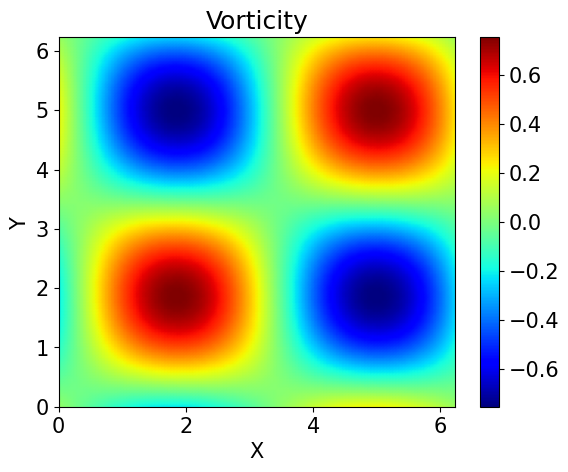

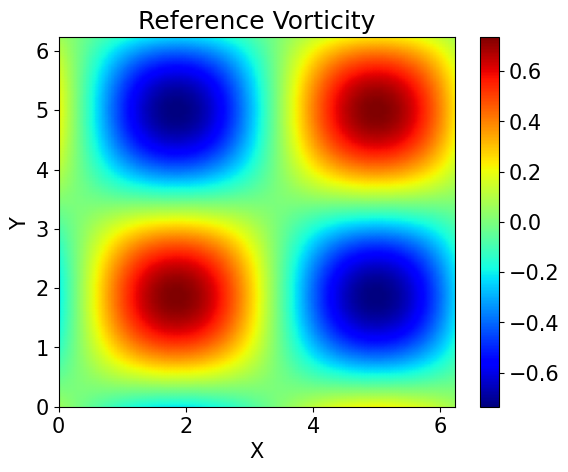

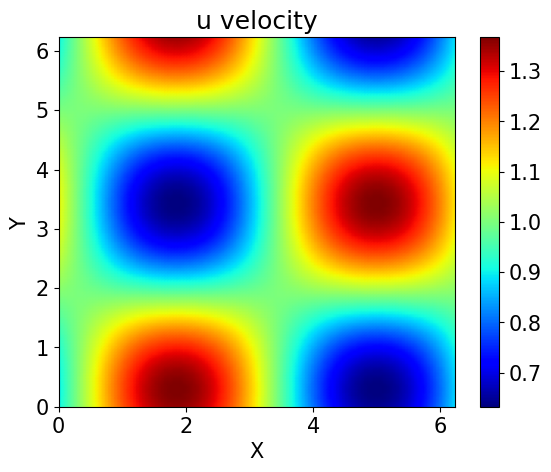

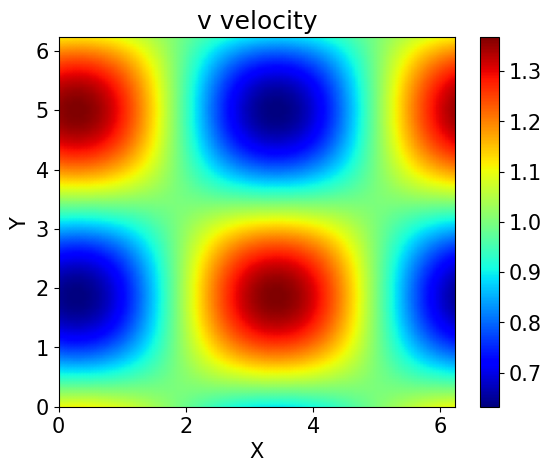

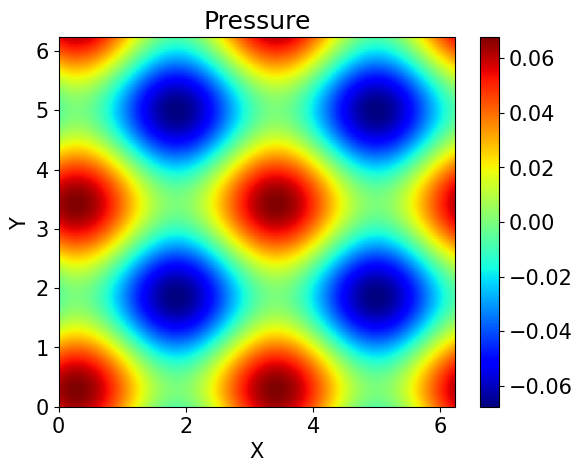

┌ Info: current Δt = 0.005, maximum stable Δt = 0.012047856934923532
└ @ Main In[11]:17
┌ Info: ("||e_ω||_2/||ω||_2 =", 0.03644693528045231)
└ @ Main In[11]:30
┌ Info: ("||e_u||_2/||u||_2 =", 0.00659342651489014)
└ @ Main In[11]:31
┌ Info: ("||e_v||_2/||v||_2 =", 0.006593426514890141)
└ @ Main In[11]:32
┌ Info: ("||e_p||_2/||p||_2 =", 0.05154366293051739)
└ @ Main In[11]:33
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/huang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(0.5, 1.0, 'Pressure')

In [11]:
ν=1.0e-1;     # viscosity
N_x=128;       # resolution in x
N_y=128;       # resolution in y
Δt=5.0e-3;    # time step
T=5.0;        # final time
method="Crank-Nicolson"  # RK4 or Crank-Nicolson
Lx, Ly = 2*pi, 2*pi
ub, vb = 1.0,1.0

mesh = Spectral_Mesh(N_x, N_y, Lx, Ly)
Δx, Δy, xx, yy = mesh.Δx, mesh.Δy, mesh.xx, mesh.yy
ω0, u0, v0, p0 = TGV_Sol(xx, yy, ν, ub, vb, 0.0)

solver = Spectral_NS_Solver(mesh, ν; ω0 = ω0, ub = ub, vb = vb)  
  
Δt_max = Stable_Δt(mesh, ν, solver.u, solver.v)
@info "current Δt = $(Δt), maximum stable Δt = $(Δt_max)"

N_t = Int64(T/Δt)
for i = 1:N_t
    Solve!(solver, Δt, method)
end

compute_pressure = true
Update_Grid_Vars!(solver, compute_pressure)


ω_sol, u_sol, v_sol, p_sol = TGV_Sol(xx, yy, ν, ub, vb, T)

@info "||e_ω||_2/||ω||_2 =", norm(solver.ω - ω_sol)/norm(ω_sol)
@info "||e_u||_2/||u||_2 =", norm(solver.u - u_sol)/norm(u_sol)
@info "||e_v||_2/||v||_2 =", norm(solver.v - v_sol)/norm(v_sol)
@info "||e_p||_2/||p||_2 =", norm(solver.p - p_sol)/norm(p_sol)



PyPlot.figure(figsize=(4,3))
Visual(mesh, solver.ω, "ω")
PyPlot.title("Vorticity")

PyPlot.figure(figsize=(4,3))
Visual(mesh, ω_sol, "ω")
PyPlot.title("Reference Vorticity")

PyPlot.figure(figsize=(4,3))
Visual(mesh, u_sol, "u")
PyPlot.title("u velocity")

PyPlot.figure(figsize=(4,3))
Visual(mesh, v_sol, "v")
PyPlot.title("v velocity")

PyPlot.figure(figsize=(4,3))
Visual(mesh, p_sol, "v")
PyPlot.title("Pressure")

## Kolmogorov Forcing 
The flow is driven by the deterministic Kolmogorov forcing 

$$ f = \Big(\sin(k_f y) ,\, 0\Big)^T $$ 

where $k_f = 4$ is the forcing wavenumber. In spite of the simplicity of the forcing and the boundary conditions, the Kolmogorov flow exhibits complex chaotic dynamics
when the Reynolds number $Re = \nu^{-1}$ is sufficiently large.


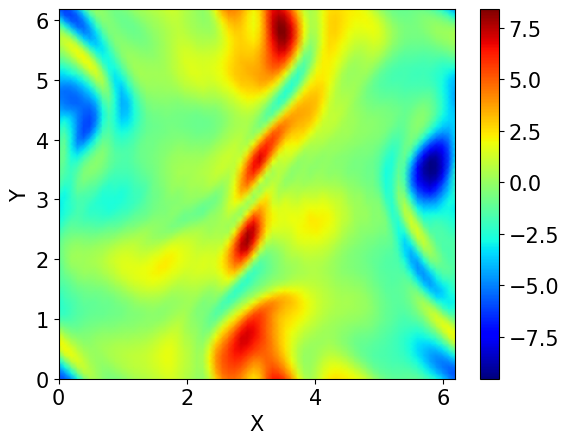

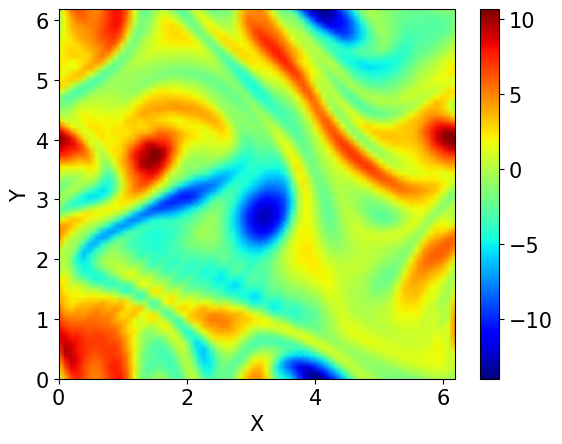

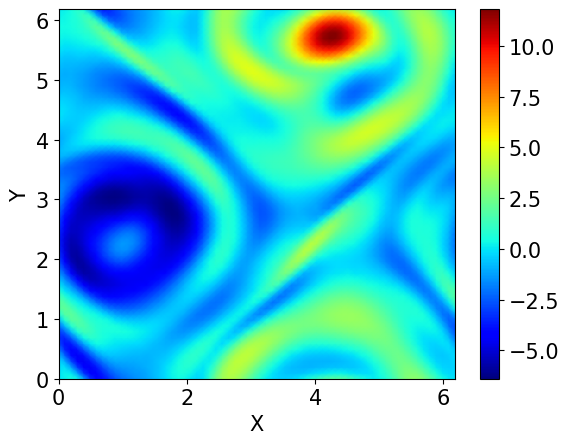

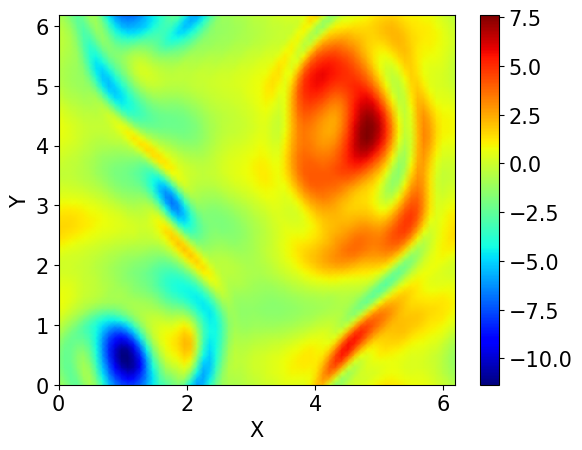

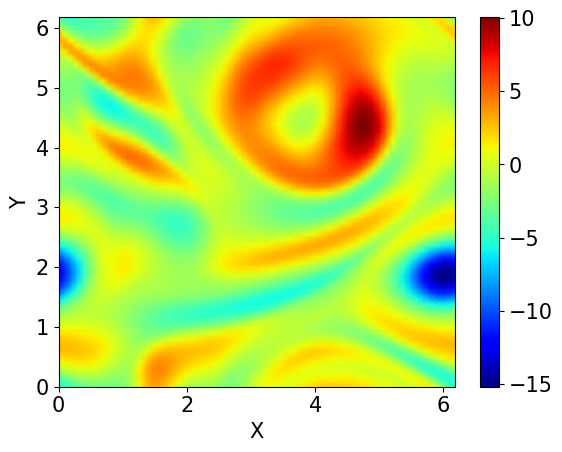

In [12]:
ν = 1.0e-2                                      # viscosity
N, L = 64, 2*pi                                 # resolution and domain size 
ub, vb = 0.0, 0.0                               # background velocity 
method="Crank-Nicolson"                         # RK4 or Crank-Nicolson
N_t = 50000;                                     # time step
T = 100.0;                                        # final time
obs_ΔNx, obs_ΔNy, obs_ΔNt = 16, 16, 5000        #observation
σ = sqrt(2)*pi
N_KL = 0
N_θ = 100

# this is used for generating random initial condition
s_param = Setup_Param(ν, ub, vb,  
    N, L,  
    method, N_t,
    obs_ΔNx, obs_ΔNy, obs_ΔNt, 
    N_KL,
    N_θ;
    f = (x, y) -> (sin(4*y), 0),
    σ = σ)

ω0_ref = s_param.ω0_ref
mesh = Spectral_Mesh(N, N, L, L)
solver = Spectral_NS_Solver(mesh, ν; fx = s_param.fx, fy = s_param.fy, ω0 = ω0_ref, ub = ub, vb = vb)  



Δt = T/N_t 
for i = 1:N_t
    Solve!(solver, Δt, method)
    
    if i%10000 == 0
        Update_Grid_Vars!(solver)
        PyPlot.figure(figsize = (4,3))
        Visual(mesh, solver.ω, "ω")
    end
end



# Inverse Problem : Optimization Approach


We study the problem of recovering the initial vorticity field from measurements
at positive times. We parameterize it as $\omega_0(x, \theta)$, defined by parameters $\theta \in \mathcal{R}^{N_{\theta}}$, and modeled as a Gaussian field with covariance operator $\mathsf{C} = \Delta^{-2}$, subject to periodic boundary conditions, on the space of spatial-mean zero functions. The KL expansion of the initial vorticity field is given by 

$$\begin{equation}
\omega_0(x, \theta) = \sum_{l\in K} \theta^{c}_{(l)} \sqrt{\lambda_{l}} \psi^c_l  +  \theta^{s}_{(l)}\sqrt{\lambda_{l}} \psi^s_l,
\end{equation}$$

where $K = \{(k_x, k_y)| k_x + k_y > 0 \textrm{ or } (k_x + k_y = 0 \textrm{ and } k_x > 0)\}$, and the eigenpairs are of the form

$$\begin{equation}
    \psi^c_l(x) =\frac{\cos(l\cdot x)}{\sqrt{2}\pi}\quad \psi^s_l(x) =\frac{\sin(l\cdot x)}{\sqrt{2}\pi} \quad \lambda_l = \frac{1}{|l|^{4}},
\end{equation}$$

and $\theta^{c}_{(l)},\theta^{s}_{(l)}  \sim \mathcal{N}(0,2\pi^2)$ i.i.d. The KL expansion can be rewritten as a sum over $\mathcal{Z}^{0+}$ rather than a lattice: 

$$\begin{equation}
    \omega_0(x,\theta) = \sum_{k\in \mathcal{Z}^{0+}} \theta_{(k)}\sqrt{\lambda_k} \psi_k(x),
\end{equation}$$

where the eigenvalues $\lambda_k$ are in descending order. 


For the inverse problem, we assume the background mean velocity $v_b = (2\pi,\,2\pi)$ is known and there is no forcing term $(f = 0)$.  We recover the initial condition, specifically the initial vorticity field of the Navier-Stokes equation, given pointwise observations $y_{ref}$ of the vorticity field at 16 equidistant points($N_y=32$) at $T=0.25$ and $T=0.5$.
The observations $y_{obs}$ are defined by adding $5\%$ Gaussian random noises as following

$$
\begin{equation}
    y_{obs} = y_{ref} + \epsilon \odot  \mathcal{N}(0, I),
\end{equation}
$$

The initial vorticity field $\omega_{0,ref}$ is generated with all $85^2$ Fourier modes, and the first $N_{\theta}=100$ KL modes are recovered. And, hence this is a mis-specified model. 


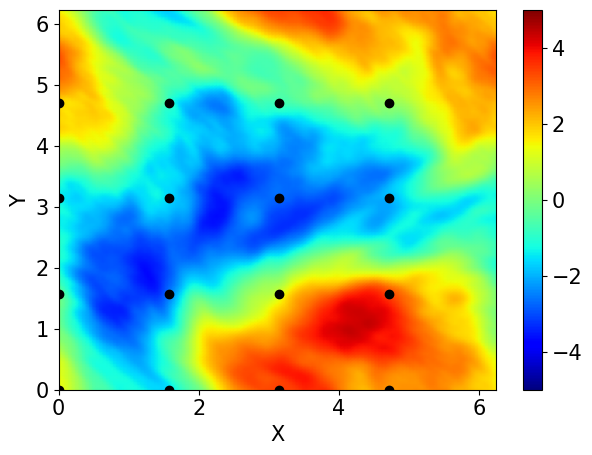

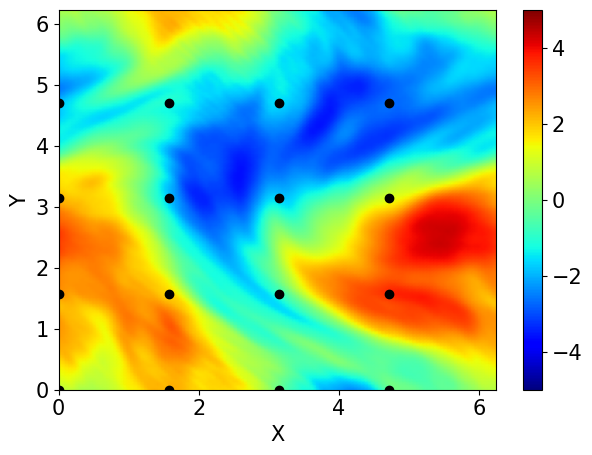

In [17]:
ν = 1.0e-2                                      # viscosity
N, L = 128, 2*pi                                 # resolution and domain size 
ub, vb = 2*pi, 2*pi                             # background velocity 
method="Crank-Nicolson"                         # RK4 or Crank-Nicolson
N_t = 2500;                                     # time step
T = 0.5;                                        # final time
obs_ΔNx, obs_ΔNy, obs_ΔNt = 32, 32, 1250         # observation
σ = sqrt(2)*pi
N_KL = 0
N_θ = 100
mesh = Spectral_Mesh(N, N, L, L)
s_param = Setup_Param(ν, ub, vb,  
    N, L,  
    method, N_t,
    obs_ΔNx, obs_ΔNy, obs_ΔNt, 
    N_KL,
    N_θ;
    σ = σ)
ω0_ref = s_param.ω0_ref

# generate observation data
y = forward_helper(s_param, ω0_ref, "NS", -5.0, 5.0);
# add noise to the data
noise_level = 0.05
Random.seed!(666);
for i = 1:length(length(y))
    noise = rand(Normal(0, noise_level*abs(y[i])))
    y[i] += noise
end


## Unscented Kalman Inversion

The UKI is initialized with $\theta_0 \sim \mathcal{N}(0, 10I)$ and the observation 
error assumed for inversion purposes is $\eta \sim \mathcal{N}(0, I)$. And this problem 
is insensitive to the observation error, and the results obtained with $\alpha = 1$ (no regularization) 
are presented.




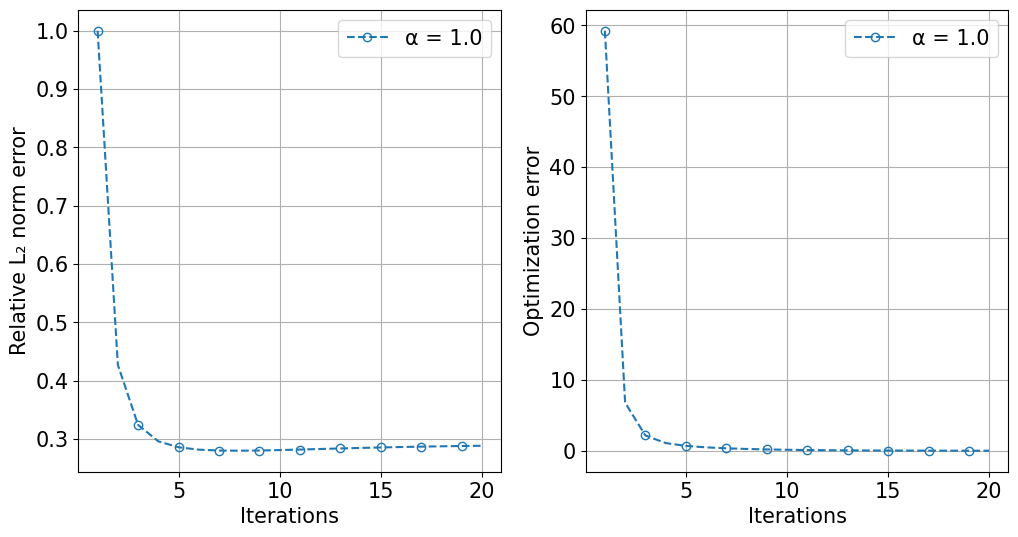

┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483


PyObject <matplotlib.legend.Legend object at 0x1b129e790>

In [20]:
Σ_η = Array(Diagonal(fill(1.0, length(y))))

# initial mean and covariance
θ0_mean = zeros(Float64, N_θ)  # mean 
θθ0_cov = Array(Diagonal(fill(10.0, N_θ)))
α_reg = 1.0
update_freq = 0
N_iter = 20
γ = 2.0
ukiobj = UKI_Run(s_param, forward, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, y, Σ_η, γ, α_reg, update_freq, N_iter)

# visulize the error
fig, ax = PyPlot.subplots(ncols = 2, sharex=true, sharey=false, figsize=(12,6))
ites = Array(1:N_iter)
errors = zeros(Float64, (2, N_iter))
for i = 1:N_iter
    errors[1, i] = norm(ω0_ref - Initial_ω0_KL(mesh, ukiobj.θ_mean[i], s_param.seq_pairs))/norm(ω0_ref)
    errors[2, i] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y)) 
end
    
ax[1].plot(ites, errors[1, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
ax[1].set_ylabel("Relative L₂ norm error")
ax[1].set_xlabel("Iterations")
ax[1].grid(true)
ax[1].legend()
        
        
ax[2].plot(ites, errors[2, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
ax[2].set_xlabel("Iterations")
ax[2].set_ylabel("Optimization error")
ax[2].grid(true)
ax[2].legend()
    




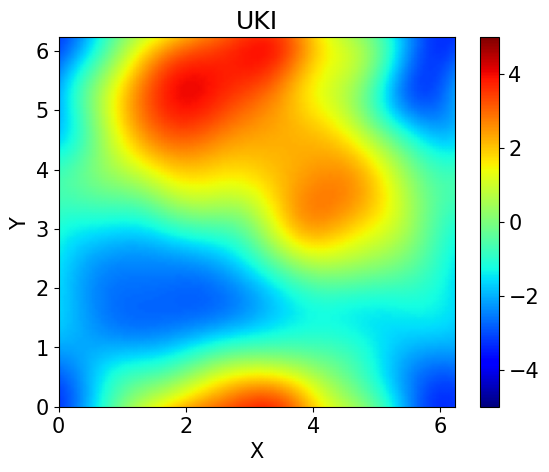

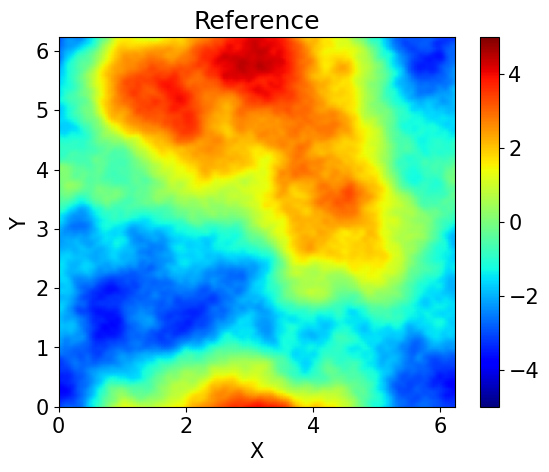

PyObject Text(0.5, 1.0, 'Reference')

In [21]:
# Initial vorticity field visualization
Visual(mesh, Initial_ω0_KL(mesh, ukiobj.θ_mean[end], s_param.seq_pairs), "ω0", "None", -5.0, 5.0)
PyPlot.title("UKI")
Visual(mesh, ω0_ref, "ω0", "None", -5.0, 5.0)
PyPlot.title("Reference")